In [19]:
from __future__ import print_function
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
from link_bot_notebooks import linear_tf_model
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, linewidth=150)

In [2]:
dataset = "../../../link_bot_teleop/data/random_50_steps.txt"
goal = np.zeros((6,1))
n_steps = 50
data = tpo.load_train(dataset, n_steps=n_steps, N=6, L=2, extract_func=tpo.link_pos_vel_extractor2(6))
print(data.shape)

(51, 8, 250)


In [3]:
args = {'checkpoint': "log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000", 'log': False, 'batch_size': 1024}
dt = 0.1
x = tpo.load_train(dataset, N=6, L=2, n_steps=n_steps, extract_func=tpo.link_pos_vel_extractor2(6))
model = linear_tf_model.LinearTFModel(args, N=6, M=2, L=2, n_steps=50, dt=dt)
model.load()

INFO:tensorflow:Restoring parameters from log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000
Restored ckpt log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000 at step 175000


In [18]:
A = model.get_A()
print(A)

[[ 0.1913 -0.4433  0.0491  0.0058 -0.0092 -0.0881]
 [-0.2548 -0.1018 -0.0238 -0.0447 -0.0941 -0.0404]]


In [79]:
def compare_predictions(example_idx):
    traj = data[:, :, example_idx]
    tf_s = traj[:1,:6].T
    tf_u = traj[:-1, [[6],[7]]]
    tf_o = model.predict_from_s(tf_s, tf_u)
    tf_s = np.linalg.lstsq(A, tf_o, rcond=None)[0]
    vx = traj[0][6]
    vy = traj[0][7]
    s = traj[0][[0, 1]]
    s_true = traj[n_steps][[0, 1]]
    s_expected = s + np.array([vx, vy]) * 0.1 * n_steps
    d_true = s_true - s
    d_expected = s_expected - s
    xy_error = s_true - s_expected
    no_dynamics_error = s_true - s
    tf_error = tf_s - s
    xy_error_d = np.linalg.norm(xy_error)
    no_dynamics_error_d = np.linalg.norm(no_dynamics_error)
    tf_error_d = np.linalg.norm(tf_error)
    print('distance error for xy model', xy_error_d)
    print('distance error for no dynamics model', no_dynamics_error_d)
    print('distance error for learned model', tf_error_d)
    if xy_error_d > no_dynamics_error_d:
        print("no dynamics does better than xy")
    if tf_error_d > no_dynamics_error_d:
        print("no dynamics does better than leanred")
    if xy_error_d > tf_error_d:
        print("learned does better than xy")
    plt.figure()
    plt.title("example {}".format(example_idx))
    plt.scatter(s[0], s[1], s=100, c='r')
    plt.scatter(traj[0, 4], traj[0, 5], s=200, c='k')
    plt.plot(traj[:, 4], traj[:, 5], label='head')
    plt.scatter(traj[0, 2], traj[0, 3], s=200, c='y')
    plt.plot(traj[:, 2], traj[:, 3], label='middle')
    plt.plot(traj[:, 0], traj[:, 1], label='tail')
    plt.plot([s[0], s_expected[0]], [s[1], s_expected[1]], label='tail expected')
    plt.plot([s[0], tf_s[0]], [s[1], tf_s[1]], label='tail learned')
    plt.axis("equal")
    plt.legend();
    
def compare_predictions_in_latent_space(example_idx):
    traj = data[:, :, example_idx]
    
    tf_s = traj[:1,:6].T
    tf_u = traj[:-1, [[6],[7]]]
    tf_o = model.reduce(traj[:1,:6].T)
    tf_o_ = model.reduce(traj[n_steps:,:6].T)
    tf_o_hat_ = model.predict_from_s(tf_s, tf_u)
    vx = traj[0][6]
    vy = traj[0][7]
    o = traj[0][[0, 1]]
    o_true = traj[n_steps][[0, 1]]
    o_expected = o + np.array([vx, vy]) * 0.1 * (n_steps - 0)
    d_true = o_true - o
    d_expected = o_expected - o
    xy_error = o_true - o_expected
    no_dynamics_error = o_true - o
    tf_error = tf_o_ - tf_o_hat_
    xy_error_d = np.linalg.norm(xy_error)
    no_dynamics_error_d = np.linalg.norm(no_dynamics_error)
    tf_error_d = np.linalg.norm(tf_error)
    
    print('distance error for xy model', xy_error_d)
    print('distance error for no dynamics model', no_dynamics_error_d)
    print('distance error for learned model', tf_error_d)
    if xy_error_d > no_dynamics_error_d:
        print("no dynamics does better than xy")
    if tf_error_d > no_dynamics_error_d:
        print("no dynamics does better than learned")
    if xy_error_d > tf_error_d:
        print("learned does better than XY")
    plt.figure()
    
    plt.title("example {} in latent space".format(example_idx))
    plt.scatter(tf_o[0], tf_o[1], s=100, c='r')
#     plt.scatter(traj[0, 4], traj[0, 5], s=200, c='k')
#     plt.plot(traj[:, 4], traj[:, 5], label='head')
#     plt.scatter(traj[0, 2], traj[0, 3], s=200, c='y')
#     plt.plot(traj[:, 2], traj[:, 3], label='middle')
#     plt.plot(traj[:, 0], traj[:, 1], label='tail')
#     plt.plot([o[0], o_expected[0]], [o[1], o_expected[1]], label='tail expected')
    plt.plot([tf_o[0], tf_o_[0]], [tf_o[1], tf_o_[1]], label='tail learned true', linewidth=5)
    plt.plot([tf_o[0], tf_o_hat_[0]], [tf_o[1], tf_o_hat_[1]], label='tail learned predicted')
    plt.axis("equal")
    plt.legend();

distance error for xy model 1.1924106394382548
distance error for no dynamics model 3.9511739968031687
distance error for learned model 8.411484430103666
no dynamics does better than leanred
distance error for xy model 1.1924106394382548
distance error for no dynamics model 3.9511739968031687
distance error for learned model 0.48309812
learned does better than XY


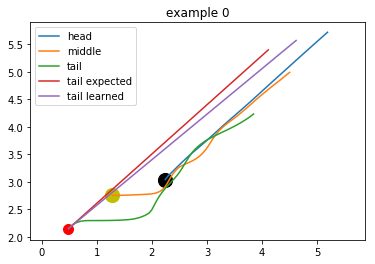

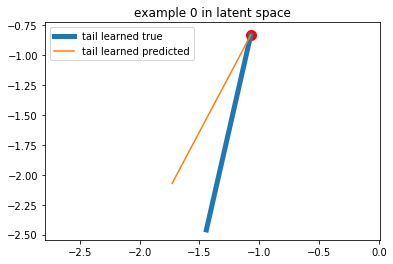

In [80]:
compare_predictions(0)
compare_predictions_in_latent_space(0)

distance error for xy model 2.0852773143911287
distance error for no dynamics model 4.601791912542786
distance error for learned model 12.205661666406206
no dynamics does better than leanred
distance error for xy model 2.0852773143911287
distance error for no dynamics model 4.601791912542786
distance error for learned model 0.84867984
learned does better than XY


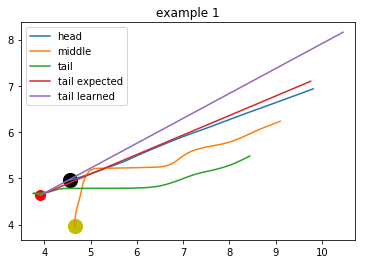

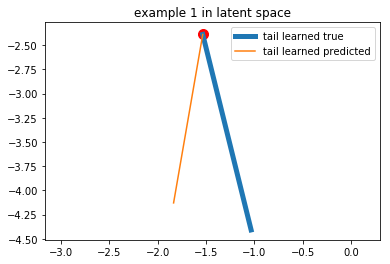

In [81]:
compare_predictions(1)
compare_predictions_in_latent_space(1)

distance error for xy model 0.9343830296246345
distance error for no dynamics model 3.7521411372922104
distance error for learned model 9.52724580711769
no dynamics does better than leanred
distance error for xy model 0.9343830296246345
distance error for no dynamics model 3.7521411372922104
distance error for learned model 0.79617697
learned does better than XY


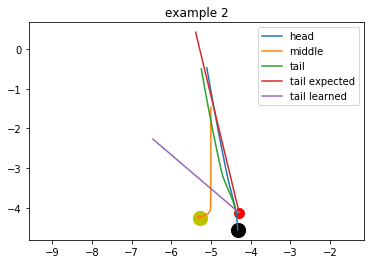

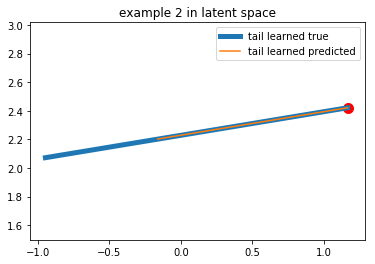

In [82]:
compare_predictions(2)
compare_predictions_in_latent_space(2)

distance error for xy model 0.8583353647831673
distance error for no dynamics model 0.04738319456896004
distance error for learned model 7.94072742402354
no dynamics does better than xy
no dynamics does better than leanred


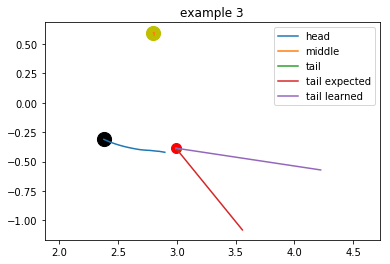

In [83]:
compare_predictions(3)

distance error for xy model 2.9614734397216482
distance error for no dynamics model 3.337584471032622
distance error for learned model 8.756728365004648
no dynamics does better than leanred
distance error for xy model 2.9614734397216482
distance error for no dynamics model 3.337584471032622
distance error for learned model 0.4838782
learned does better than XY


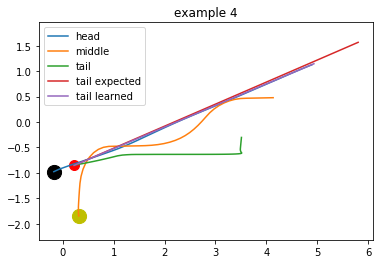

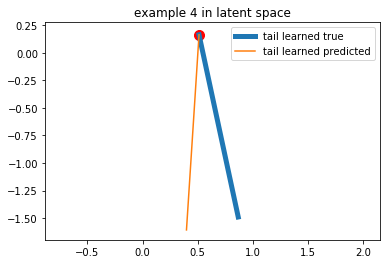

In [84]:
compare_predictions(4)
compare_predictions_in_latent_space(4)

distance error for xy model 3.014662933925745
distance error for no dynamics model 3.5338792453492758
distance error for learned model 6.315743280240874
no dynamics does better than leanred
distance error for xy model 3.014662933925745
distance error for no dynamics model 3.5338792453492758
distance error for learned model 0.17465061
learned does better than XY


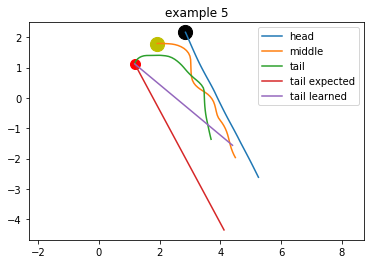

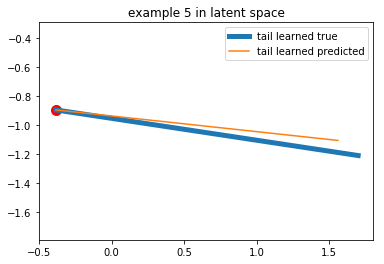

In [85]:
compare_predictions(5)
compare_predictions_in_latent_space(5)

distance error for xy model 3.751885304147907
distance error for no dynamics model 0.3965826434405892
distance error for learned model 14.79832421525566
no dynamics does better than xy
no dynamics does better than leanred
distance error for xy model 3.751885304147907
distance error for no dynamics model 0.3965826434405892
distance error for learned model 0.5798167
no dynamics does better than xy
no dynamics does better than learned
learned does better than XY


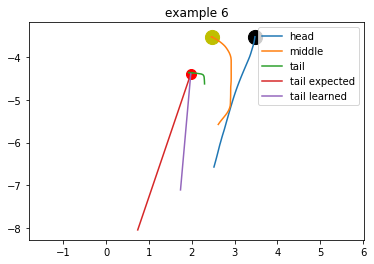

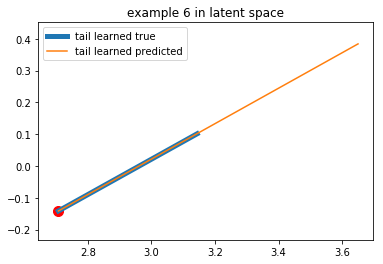

In [86]:
compare_predictions(6)
compare_predictions_in_latent_space(6)

distance error for xy model 2.64759793498682
distance error for no dynamics model 7.170752298932582
distance error for learned model 13.044776053785359
no dynamics does better than leanred
distance error for xy model 2.64759793498682
distance error for no dynamics model 7.170752298932582
distance error for learned model 0.9210271
learned does better than XY


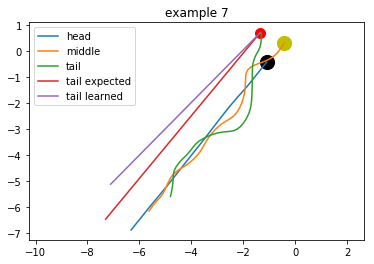

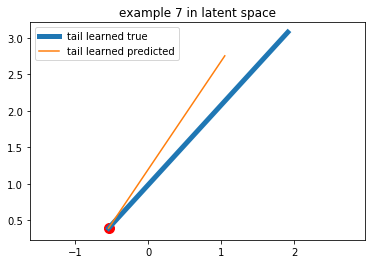

In [90]:
compare_predictions(7)
compare_predictions_in_latent_space(7)

In [88]:
f = 0.0
m = 0
xy_error_sum = 0
no_dynamics_error_sum = 0
tf_error_sum = 0
for i in range(data.shape[2]):
    traj = data[:, :, i]
    tf_s = traj[:1,:6].T
    tf_u = traj[:-1, [[6],[7]]]
    tf_o = model.predict_from_s(tf_s, tf_u)
    vx = traj[0][6]
    vy = traj[0][7]
    o = traj[0][[0, 1]]
    o_true = traj[n_steps][[0, 1]]
    o_true_tf = model.reduce(traj[n_steps:,:6].T)
    o_expected = o + np.array([vx, vy]) * 0.1 * (n_steps - 0)
    d_true = o_true - o
    d_expected = o_expected - o
    xy_error = o_true - o_expected
    no_dynamics_error = o_true - o
    tf_error = o_true_tf - tf_o
    xy_error_d = np.linalg.norm(xy_error)
    no_dynamics_error_d = np.linalg.norm(no_dynamics_error)
    tf_error_d = np.linalg.norm(tf_error)
    xy_error_sum += xy_error_d
    no_dynamics_error_sum += no_dynamics_error_d
    tf_error_sum += tf_error_d
    
xy_loss = xy_error_sum/ data.shape[2]
no_dynamics_loss = no_dynamics_error_sum/ data.shape[2]
tf_loss = tf_error_sum/ data.shape[2]
print('loss of XY dynamics:', xy_loss)
print('loss of no dynamics:', no_dynamics_loss)
print('loss of TF dynamics:', tf_loss)
if xy_loss > no_dynamics_loss:
    print("VERY SAD.")
else:
    print("Success!!!")

loss of XY dynamics: 1.7919841946027308
loss of no dynamics: 1.9752064384975276
loss of TF dynamics: 0.40863815347850324
Success!!!


In [89]:
d_sum = 0
for i in range(data.shape[2]):
    traj = data[:, :, i]
    vx = traj[0][6]
    vy = traj[0][7]
    s = traj[0][[0, 1]]
    s_true = traj[n_steps][[0, 1]]
    d_true = np.linalg.norm(s_true - s)
    d_sum += d_true
    
print("average displacement for random {} time-step actions: {}".format(n_steps, d_sum / data.shape[2]))

average displacement for random 50 time-step actions: 1.9752064385
